In [119]:
import numpy as np
import torch as th
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os, glob, tqdm
import torchvision.transforms.functional as F
from torchvision.io import read_image
from pathlib import Path
import cv2
from torchvision.utils import make_grid

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
def face_segment(segment_part, img):
    
    if isinstance(img, Image.Image):
        face_segment_anno = np.array(img)
    else:
        face_segment_anno = img
        
    bg = (face_segment_anno == 0)
    skin = (face_segment_anno == 1)
    l_brow = (face_segment_anno == 2)
    r_brow = (face_segment_anno == 3)
    l_eye = (face_segment_anno == 4)
    r_eye = (face_segment_anno == 5)
    eye_g = (face_segment_anno == 6)
    l_ear = (face_segment_anno == 7)
    r_ear = (face_segment_anno == 8)
    ear_r = (face_segment_anno == 9)
    nose = (face_segment_anno == 10)
    mouth = (face_segment_anno == 11)
    u_lip = (face_segment_anno == 12)
    l_lip = (face_segment_anno == 13)
    neck = (face_segment_anno == 14)
    neck_l = (face_segment_anno == 15)
    cloth = (face_segment_anno == 16)
    hair = (face_segment_anno == 17)
    hat = (face_segment_anno == 18)
    face = np.logical_or.reduce((skin, l_brow, r_brow, l_eye, r_eye, eye_g, l_ear, r_ear, ear_r, nose, mouth, u_lip, l_lip))

    if segment_part == 'faceseg_face':
        seg_m = face
    elif segment_part == 'faceseg_head':
        seg_m = (face | neck | hair)
    elif segment_part == 'faceseg_nohead':
        seg_m = ~(face | neck | hair)
    elif segment_part == 'faceseg_face&hair':
        seg_m = ~bg
    elif segment_part == 'faceseg_bg_noface&nohair':
        seg_m = (bg | hat | neck | neck_l | cloth) 
    elif segment_part == 'faceseg_bg&ears_noface&nohair':
        seg_m = (bg | hat | neck | neck_l | cloth) | (l_ear | r_ear | ear_r)
    elif segment_part == 'faceseg_bg':
        seg_m = bg
    elif segment_part == 'faceseg_bg&noface':
        seg_m = (bg | hair | hat | neck | neck_l | cloth)
    elif segment_part == 'faceseg_hair':
        seg_m = hair
    elif segment_part == 'faceseg_faceskin':
        seg_m = skin
    elif segment_part == 'faceseg_faceskin&nose':
        seg_m = (skin | nose)
    elif segment_part == 'faceseg_faceskin&nose&mouth&eyebrows':
        seg_m = (skin | nose | mouth | u_lip | l_lip | l_brow | r_brow | l_eye | r_eye)
    elif segment_part == 'faceseg_faceskin&nose&mouth&eyebrows&eyes&glasses':
        seg_m = (skin | nose | mouth | u_lip | l_lip | l_brow | r_brow | l_eye | r_eye | eye_g)
        # seg_m = (skin | nose | mouth | u_lip | l_lip | l_brow | r_brow)
    elif segment_part == 'faceseg_face_noglasses':
        seg_m = (~eye_g & face)
    elif segment_part == 'faceseg_face_noglasses_noeyes':
        seg_m = (~(l_eye | r_eye) & ~eye_g & face)
    elif segment_part == 'faceseg_eyes&glasses':
        seg_m = (l_eye | r_eye | eye_g)
    elif segment_part == 'glasses':
        seg_m = eye_g
    elif segment_part == 'faceseg_eyes':
        seg_m = (l_eye | r_eye)
    # elif (segment_part == 'sobel_bg_mask') or (segment_part == 'laplacian_bg_mask') or (segment_part == 'sobel_bin_bg_mask'):
    elif segment_part in ['sobel_bg_mask', 'laplacian_bg_mask', 'sobel_bin_bg_mask']:
        seg_m = ~(face | neck | hair)
    elif segment_part in ['canny_edge_bg_mask']:
        seg_m = ~(face | neck | hair) | (l_ear | r_ear)
    else: raise NotImplementedError(f"Segment part: {segment_part} is not found!")
    
    out = seg_m
    return out

def get_shadow_diff(img1, img2, c_type='L', signed=False):
    # Compute Shadow Difference
    img1 = np.array(img1.convert(c_type)) / 255.0
    img2 = np.array(img2.convert(c_type)) / 255.0
    if signed:
        shadow_diff = img2 - img1
    else:
        shadow_diff = np.abs(img2 - img1)
    return shadow_diff

def create_image_grid(images, n_rows=1, text_labels=[]):
    """
    Creates a grid of images from a list of NumPy arrays.
    
    Parameters:
    - images: List of np.array, each representing an image.
    - n_rows: Number of rows in the grid.
    
    Returns:
    - A matplotlib figure containing the image grid.
    """
    n_images = len(images)
    n_cols = (n_images + n_rows - 1) // n_rows  # Calculate number of columns needed
    
    # Get the height and width of the images (assuming all images are the same size)
    # img_height, img_width = images[0].shape[:2]

    # Add zero images if the number of images is less than needed to fill the grid
    images += [np.zeros_like(images[0]) for _ in range(n_rows * n_cols - n_images)]
    
    # Create the grid by concatenating images
    rows = []
    for i in range(n_rows):
        row_images = images[i * n_cols:(i + 1) * n_cols]
        rows.append(np.concatenate(row_images, axis=1))
    
    grid_image = np.concatenate(rows, axis=0)

    # Add text labels to the grid
    img_height, img_width = images[0].shape[:2]
    for i, text_label in enumerate(text_labels):
        # plt.text((i % n_cols) * img_width, (i // n_cols) * img_height, text_label, color='red', fontsize=12)
        if isinstance(text_label, str):
            plt.text((i % n_cols) * img_width, -2, text_label, color='red', fontsize=20)
        else:
            plt.text((i % n_cols) * img_width, -2, f'{float(text_label):.5f}', color='red', fontsize=20)

    return grid_image


[['69380.jpg' 7.383497233314015]
 ['68578.jpg' 7.146139401438161]
 ['69867.jpg' 7.108911592210779]
 ['66921.jpg' 7.061488585299044]
 ['67967.jpg' 7.051946486725518]]
[['68171.jpg' -4.2652459207145]
 ['66632.jpg' -4.312319330952065]
 ['61117.jpg' -4.421887479727907]
 ['68065.jpg' -4.683639649386844]
 ['69193.jpg' -4.985533880236826]]
Min-Max c-values:  -4.985533880236826 7.383497233314015


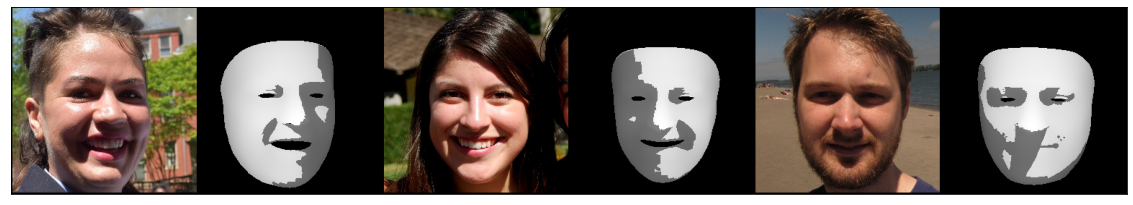

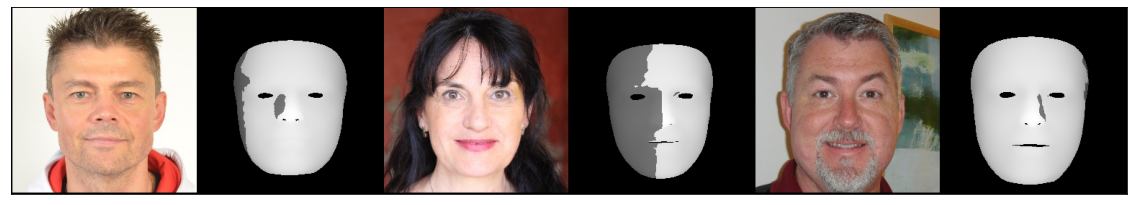

In [120]:
data_path = '/data/mint/DPM_Dataset/ffhq_256_with_anno/'
set_ = 'valid'
c_p = f'{data_path}/params/{set_}/ffhq-{set_}-shadow-anno.txt'
img_p = f'{data_path}/ffhq_256/{set_}/'
ray_p = f'{data_path}/shadow_masks/{set_}/'

c = pd.read_csv(c_p, sep=' ', header=None, names=['image_name', 'c_val'])
c_sorted = c.sort_values(by=['c_val'], ascending=False)
print(c_sorted.head(5).values)
print(c_sorted.tail(5).values)
print("Min-Max c-values: ", c_sorted['c_val'].min(), c_sorted['c_val'].max())

n = 3
img_top_n = [read_image(f'{img_p}/{c_sorted.iloc[i, 0]}') for i in range(n)]
ray_top_n = [read_image(f"{ray_p}/{c_sorted.iloc[i, 0].replace('.jpg', '.png')}") for i in range(n)]
img_bot_n = [read_image(f'{img_p}/{c_sorted.iloc[i, 0]}') for i in range(-1, -n-1, -1)]
ray_bot_n = [read_image(f"{ray_p}/{c_sorted.iloc[i, 0].replace('.jpg', '.png')}") for i in range(-1, -n-1, -1)]

# Combined n list into 1 list
vis_top_n = sum([[img_top_n[i], ray_top_n[i]] for i in range(n)], [])
vis_bot_n = sum([[img_bot_n[i], ray_bot_n[i]] for i in range(n)], [])

show(make_grid(vis_top_n))
show(make_grid(vis_bot_n))

In [121]:
shadow_diff_path = f'/data/mint/DPM_Dataset/ffhq_256_with_anno/shadow_diff/median5_5e-2/{set_}/'
mask_from_rt_path = f'/data/mint/DPM_Dataset/ffhq_256_with_anno/shadow_masks/{set_}/'

def gen_shadow_diff_with_weight(img, sd_img, weight, mask_rt, vis=False):
    # sd_img is (H, W)
    # weight near 1 is more shadow, near 0 is less shadow
    # print(f"Shadow image: {sd_img.max()}, {sd_img.min()}")
    # print(f"Shape: ", sd_img.shape)
    # print(f"Weight: {weight}")
    
    # print(np.unique(sd_img))
    assert list(np.unique(sd_img)) == [0, 127, 255] or list(np.unique(sd_img)) == [127, 255]
    sd_img = np.repeat(sd_img[..., None], 3, -1)
    sd_no_shadow = sd_img == 255
    sd_grey_area = sd_img == 127
    sd_shadow = sd_img == 0
    
    sd_img = sd_img / 255.
    if vis:
        plt.figure(figsize=(30, 30))
        plt.imshow(create_image_grid([
            img/255.,
            sd_img,
            sd_no_shadow,
            sd_grey_area,
            sd_shadow,
            (sd_img + weight) * sd_shadow + (sd_img * sd_no_shadow),
            (((sd_img + weight) * sd_shadow + (sd_img * sd_no_shadow)) * ~sd_grey_area) + (sd_img * sd_grey_area),
            (((sd_img) * sd_shadow + (sd_img * sd_no_shadow)) * ~sd_grey_area) + (sd_img * sd_grey_area),
            (((sd_img + 0.2) * sd_shadow + (sd_img * sd_no_shadow)) * ~sd_grey_area) + (sd_img * sd_grey_area),
            (((sd_img + 0.4) * sd_shadow + (sd_img * sd_no_shadow)) * ~sd_grey_area) + (sd_img * sd_grey_area),
            (((sd_img + 0.6) * sd_shadow + (sd_img * sd_no_shadow)) * ~sd_grey_area) + (sd_img * sd_grey_area),
            (((sd_img + 0.8) * sd_shadow + (sd_img * sd_no_shadow)) * ~sd_grey_area) + (sd_img * sd_grey_area),
            (((sd_img + 1) * sd_shadow + (sd_img * sd_no_shadow)) * ~sd_grey_area) + (sd_img * sd_grey_area),
        ], n_rows=1, text_labels=[
            'img', 
            'sd',
            'no_c',
            'gray',
            'c',
            'W',
            'W & Inp'
            
        ]), cmap='gray')
        plt.show()
    
        plt.imshow(create_image_grid([
            img/255., 
            sd_img,
            sd_no_shadow,
            sd_shadow,
            sd_grey_area,
        ], n_rows=1, text_labels=['img', 'shadow_diff', 'face', 'shadow', 'bg']), cmap='gray')
        plt.show()
        
    face = ((sd_img + weight) * sd_shadow) + (sd_img * sd_no_shadow)
    if vis:
        plt.imshow(create_image_grid([
            img/255., 
            sd_img,
            (1-sd_img) == sd_shadow,
            face,
            (1-face) * sd_shadow,
            sd_grey_area,
            mask_rt > 0,
            ~sd_grey_area & (mask_rt > 0)
        ], n_rows=1, text_labels=['img', 'shadow_diff', '1-sd=sd_shadow', 'face', 'shadow', 'bg', 'mask_rt', 'bg&mrt']), cmap='gray')
        plt.show()
        
        print(np.unique(face))
        print(np.unique(1-face))
        
        w_arr = [0, 0.2, 0.4, 0.6, 0.8, 1]
        face_l = [((sd_img + w) * sd_shadow) + (sd_img * sd_no_shadow) for w in w_arr]
        plt.imshow(create_image_grid(
            face_l, n_rows=1, text_labels=w_arr), cmap='gray')
        plt.show()
        
        plt.imshow(create_image_grid(
            [(1-f) * sd_shadow for f in face_l], n_rows=1, text_labels=w_arr), cmap='gray')
        plt.show()
    
    final_mask = ~sd_grey_area & (mask_rt > 0)
    return face * final_mask, ((1-face) * sd_shadow) * final_mask, final_mask
    


print(c_sorted[c_sorted['c_val'] < 3].head(5).values)
save_path = f'/data/mint/DPM_Dataset/ffhq_256_with_anno/shadow_diff_with_weight_onehot/{set_}'
os.makedirs(save_path, exist_ok=True)
# for img_path in glob.glob(f'{shadow_diff_path}/*.png')[50:55]:
# for img_path in [f'{shadow_diff_path}/60065.png', f'{shadow_diff_path}/68534.png', f'{shadow_diff_path}/63679.png', f'{shadow_diff_path}/62514.png']:
for img_path in tqdm.tqdm(glob.glob(f'{shadow_diff_path}/*.png')):
    img_name = img_path.split('/')[-1].split('.')[0]
    
    img = np.array(Image.open(f'{img_p}/{img_name}.jpg'))
    shadow_diff_img = np.array(Image.open(img_path))
    shadow_value = c[c['image_name'] == f'{img_name}.jpg']['c_val'].values[0]
    mask_from_rt = f'{mask_from_rt_path}/{img_name}.png'
    mask_from_rt = np.array(Image.open(mask_from_rt))
    
    
    # Normalize shadow_value from [-c, c] to [0, 1]
    # print(f"Before scale-C: {shadow_value}")
    shadow_value = (shadow_value - c['c_val'].min()) / (c['c_val'].max() - c['c_val'].min())
    # Switch 1 when c is negative and 0 when c is positive
    # print(f"After scale-C: {shadow_value}")
    shadow_value = 1 - shadow_value
    # print(f"After switch-C: {shadow_value}")
    # face, shadow, bg = gen_shadow_diff_with_weight(img, shadow_diff_img, shadow_value, mask_from_rt, vis=True)
    face, shadow, bg = gen_shadow_diff_with_weight(img, shadow_diff_img, shadow_value, mask_from_rt, vis=False)
    bg = ~bg
    # plt.imshow(create_image_grid([
    #     img/255.,
    #     face,
    #     shadow,
    #     bg
    # ], n_rows=1, text_labels=['img', 'face', 'shadow', 'bg']), cmap='gray')
    # plt.show()
    # print("Value output of face, shadow, bg: ")
    # print(np.unique(face))
    # print(np.unique(shadow))
    # print(np.unique(bg))
    # print(face.shape, shadow.shape, bg.shape)
    assert np.all(face[..., 0] == face[..., 1]) and np.all(face[..., 0] == face[..., 2])
    assert np.all(shadow[..., 0] == shadow[..., 1]) and np.all(shadow[..., 0] == shadow[..., 2])
    assert np.all(bg[..., 0] == bg[..., 1]) and np.all(bg[..., 0] == bg[..., 2])
    out = np.concatenate([face[..., 0:1], shadow[..., 0:1], bg[..., 0:1]], axis=-1)
    # print(out.shape)
    np.save(f'{save_path}/{img_name}.npy', out)
    # assert False
    
    


[['63679.jpg' 2.997636121823502]
 ['60365.jpg' 2.996099880819805]
 ['61405.jpg' 2.9960733404433544]
 ['63279.jpg' 2.9914535944893386]
 ['62595.jpg' 2.988685032034368]]


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [19:42<00:00,  8.46it/s] 
